# Classifying Diabetes Status: Modeling


## Import Libraries

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from functools import reduce

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

import random
random.seed(42)

## Load Data

In [3]:
# read in the data
df=pd.read_csv('./data/diabetes_clean.csv')
df.head()

,Unnamed: 0,PAQ650,PAQ605,PAQ620,PAQ635,PAQ665,RIAGENDR,RIDAGEYR,RIDRETH3,INDFMPIR,...,BMXWAIST,BMXHIP,BPXOSY2,BPXODI2,DIQ010,MCQ300C,SMQ040,RHQ160,BPQ020,wh_ratio
0,1,0,0,0,0,0,2,13,1,0.83,...,63.800000,85.000000,109.00000,68.000000,0,0,2,0,0,0.750588
1,2,0,0,0,0,0,1,2,3,3.06,...,41.200000,105.695821,119.74237,71.508478,0,0,2,0,0,0.389798
2,3,1,2,2,2,1,2,29,6,5.00,...,117.900000,126.100000,99.00000,55.000000,0,1,2,0,2,0.934972
3,4,1,2,2,2,2,2,21,2,5.00,...,90.201228,105.695821,119.74237,71.508478,0,2,2,0,2,0.853404
4,5,2,1,1,2,2,2,18,3,1.66,...,90.201228,105.695821,119.74237,71.508478,0,0,2,0,2,0.853404


In [4]:
# drop Unnamed: 0 column
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
# check for null values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13671 entries, 0 to 13670
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PAQ650    13671 non-null  int64  
 1   PAQ605    13671 non-null  int64  
 2   PAQ620    13671 non-null  int64  
 3   PAQ635    13671 non-null  int64  
 4   PAQ665    13671 non-null  int64  
 5   RIAGENDR  13671 non-null  int64  
 6   RIDAGEYR  13671 non-null  int64  
 7   RIDRETH3  13671 non-null  int64  
 8   INDFMPIR  13671 non-null  float64
 9   BMXBMI    13671 non-null  float64
 10  BMXWAIST  13671 non-null  float64
 11  BMXHIP    13671 non-null  float64
 12  BPXOSY2   13671 non-null  float64
 13  BPXODI2   13671 non-null  float64
 14  DIQ010    13671 non-null  int64  
 15  MCQ300C   13671 non-null  int64  
 16  SMQ040    13671 non-null  int64  
 17  RHQ160    13671 non-null  int64  
 18  BPQ020    13671 non-null  int64  
 19  wh_ratio  13671 non-null  float64
dtypes: float64(7), int64(13)
mem

---
# Modeling

---
> We will add more features and train a few models and optimize for recall. We will use the following potential predictive features:

        - age
        - waist measurement
        - hip measurement
        - BMI
        - physical activity features
        - Race
        - High blood pressure
        - Pedigree
        - smoking status
        - number of pregnancies

In [6]:
# create a dataframe with potential predictors
df= df[['PAQ650', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ665', 'RIAGENDR','RIDAGEYR', 
        'RIDRETH3','BMXBMI','DIQ010', 'MCQ300C', 'SMQ040', 'RHQ160', 'BPQ020','wh_ratio']]

In [7]:
# List of columns that will be dummified
cat_cols = ['PAQ650', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ665', 'RIAGENDR', 
            'RIDRETH3', 'MCQ300C', 'SMQ040', 'BPQ020']
# Dummify categorical columns
df= pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [8]:
# check the dummified columns
df.head()

,RIDAGEYR,BMXBMI,DIQ010,RHQ160,wh_ratio,PAQ650_1,PAQ650_2,PAQ605_1,PAQ605_2,PAQ620_1,...,RIDRETH3_3,RIDRETH3_4,RIDRETH3_6,RIDRETH3_7,MCQ300C_1,MCQ300C_2,SMQ040_1,SMQ040_2,BPQ020_1,BPQ020_2
0,13,17.600000,0,0,0.750588,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,15.000000,0,0,0.389798,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,29,37.800000,0,0,0.934972,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,1
3,21,26.934496,0,0,0.853404,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
4,18,26.934496,0,0,0.853404,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,1


### Null Model
- The baseline accuracy is 87%. 
   

In [9]:
# baseline accuracy 
df['DIQ010'].value_counts(normalize=True)

0    0.873674
1    0.126326
Name: DIQ010, dtype: float64

In [10]:
# set up X and y
X = df.drop(columns = ['DIQ010'])
y = df['DIQ010']

## Logistic Regression

Baseline Model

In [11]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [12]:
# logistic regression
log=LogisticRegression(max_iter = 2000)
log.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [13]:
# a function for metrics of a binary classification
def binary_metrics(X_train, y_train, X_test, y_test, model):
    y_pred=model.predict(X_test)

    acc_test=metrics.accuracy_score(y_test, y_pred)
    recall_test=metrics.recall_score(y_test, y_pred)
    
    y_preds_train = model.predict(X_train)
    acc_rain=metrics.accuracy_score(y_train, y_preds_train)
    recall_rain=metrics.recall_score(y_train, y_preds_train)
    
    print('\nTrain Accuracy:', round(acc_rain,8))
    print('Test Accuracy:', round(acc_test,8))
    
    print('\nTrain Recall:', round(recall_rain,8))
    print('Test Recall:', round(recall_test,8))
    
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test))
    
    print('\n Confusion Matrix of Test Data')
    plot_confusion_matrix(model, X_test, y_test, cmap='Oranges', values_format='d')
    
    metrics.plot_roc_curve(model, X_test, y_test) 
    plt.show()


Train Accuracy: 0.88344875
Test Accuracy: 0.87653599

Train Recall: 0.27953668
Test Recall: 0.24305556
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2986
           1       0.53      0.24      0.33       432

    accuracy                           0.88      3418
   macro avg       0.71      0.61      0.63      3418
weighted avg       0.85      0.88      0.86      3418


 Confusion Matrix of Test Data


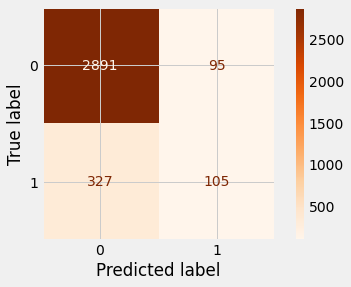

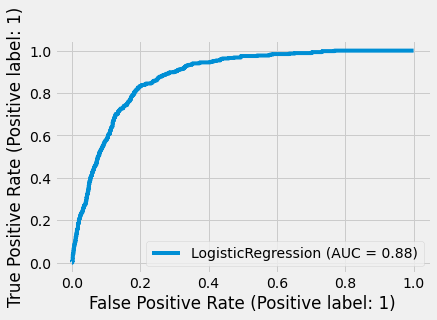

In [14]:
binary_metrics(X_train, y_train, X_test, y_test, log)

Interpretation of Metrics:
- **Accuracy - 88%**: Accuracy for this model is almost the same as baseline.
+ **Recall of `class 1` - 24%**: We only identified 24% of the actual diabetic app users! We don't prefer this outcome.
+ Precision of class 1 - 53%: When we predicted Class 1, we got it right 53% of the time. So, 47% of the app users who are not diabetic were classified as such. Though we are not optimizing for precision, we notice that its on the lower side.

## Voting classifier: 
> #### kNN, Logistic Regression, Random Forest, Multinomial Naive Bayes

In [20]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# instantiate models (voting hard)
clf1 = KNeighborsClassifier(n_neighbors=7)
clf2 = LogisticRegression(max_iter = 1000)
clf3 = RandomForestClassifier()
clf4 = MultinomialNB(fit_prior=True)
    # create a voting classifer
vote1 = VotingClassifier(estimators= [('knn', clf1), ('lr', clf2), ('rf', clf3), ('nb', clf4)], voting='hard')

In [21]:
# fit voting classifer
vote1.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('rf', RandomForestClassifier()),
                             ('nb', MultinomialNB())])

In [23]:
# a function for metrics of a binary classification

y_pred=vote1.predict(X_test)

acc_test=metrics.accuracy_score(y_test, y_pred)
recall_test=metrics.recall_score(y_test, y_pred)
    
y_preds_train = vote1.predict(X_train)
acc_rain=metrics.accuracy_score(y_train, y_preds_train)
recall_rain=metrics.recall_score(y_train, y_preds_train)
    
print('\nTrain Accuracy:', round(acc_rain,8))
print('Test Accuracy:', round(acc_test,8))
    
print('\nTrain Recall:', round(recall_rain,8))
print('Test Recall:', round(recall_test,8))
    
y_pred_test = vote1.predict(X_test)

print(classification_report(y_test, y_pred_test))
    


Train Accuracy: 0.9133912
Test Accuracy: 0.87741369

Train Recall: 0.37065637
Test Recall: 0.19444444
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2986
           1       0.54      0.19      0.29       432

    accuracy                           0.88      3418
   macro avg       0.72      0.59      0.61      3418
weighted avg       0.85      0.88      0.85      3418



In [64]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# instantiate models (voting soft)
clf1 = KNeighborsClassifier(n_neighbors=7)
clf2 = LogisticRegression(max_iter = 1000)
clf3 = RandomForestClassifier(n_estimators=100)
clf4 = MultinomialNB(fit_prior=True)
    # create a voting classifer
vote2 = VotingClassifier(estimators= [('knn', clf1), ('lr', clf2), ('rf', clf3), ('nb', clf4)], voting='soft')
    # fit voting classifer
vote2.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('rf', RandomForestClassifier()),
                             ('nb', MultinomialNB())],
                 voting='soft')

Train Accuracy: 0.9275334
Test Accuracy: 0.86775892

Train Recall: 0.5953668
Test Recall: 0.33333333

Train Specificity: 0.97555258
Test Specificity: 0.94507703

Train Precision: 0.77878788
Test Precision: 0.46753247

 Confusion Matrix of Test Data


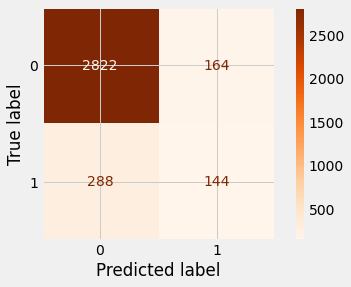

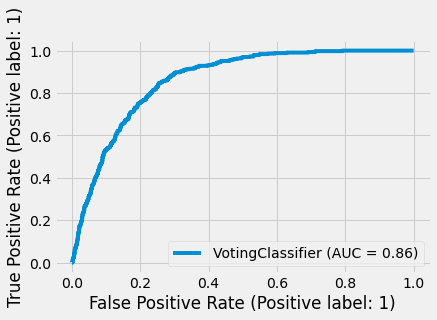

In [65]:
# Run Function to evaluate our model
class_metrics(X_train, y_train, X_test,y_test, vote2);

Eventhough the accuracy score is good for all the models. Our recall score is very low in all of the models except  multinomial naive bayes. For example the logsitic regression model has a lot of false negatives than false positives which explains the low recall score. This could be due to data imbalance. Lets try and use the weighted class technique to help lower the false negatives.

> ### Logistic regression Weighted Class

In [137]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [138]:
lr_pipe = Pipeline([
    ('lr', LogisticRegression()),
])

# find the optimal hyperparameters.
pipe_params ={
    'lr__C' : [1.0, 0.1, 0.01, 0.001],
    'lr__penalty': ['l1', 'l2','none'],
    'lr__class_weight': ['balanced'],
    'lr__max_iter': [3000],
    'lr__solver': ['saga']
    
}

# Gridsearch using the specified hyper parameters.
lr_weight = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
    , scoring = 'recall'
    , return_train_score=True
)

# Fit our training data to the Grisearch.
lr_weight.fit(X_train, y_train)
print(lr_weight.best_estimator_)
print(lr_weight.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('lr',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=3000, penalty='l1',
                                    solver='saga'))])
0.8486486486486486



Train Accuracy: 0.7588023
Test Accuracy: 0.7668227

Train Recall: 0.85328185
Test Recall: 0.86342593
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      2986
           1       0.34      0.86      0.48       432

    accuracy                           0.77      3418
   macro avg       0.66      0.81      0.67      3418
weighted avg       0.89      0.77      0.80      3418


 Confusion Matrix of Test Data


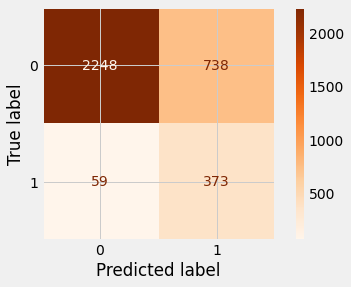

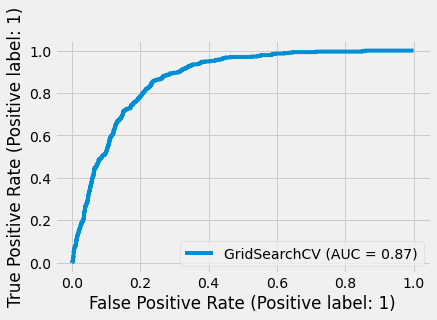

In [169]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test, y_test, lr_weight);

Interpretation of Metrics:
+ **Recall of `class 1` - 86%**: We identified 86% of the actual diabetic app users, which is a significant improvement from the baseline model of a recall of 24%.
+ **Precision of `class 1` - 34%**: Precision went down from 53% to 34% comparing to the baseline logistic regression model. Though we are not optimizing for precision, we notice that its on the lower side.
+ **AUC - 0.87**: The AUC is more or less similar to the baseline logisitc regression model.



> ### Random Forest Weighted Class: 


In [125]:
rf = RandomForestClassifier()

# gridsearch 
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', .5],
    'bootstrap': [True, False],
    'random_state': [42],
    'class_weight': ["balanced_subsample"]
}
gs_rf = GridSearchCV(rf
                     , rf_params
                     , cv=5
                     , n_jobs=-1
                     , verbose=1
                     , scoring = 'recall'
                    , return_train_score=True)
gs_rf.fit(X_train, y_train)

# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_estimator_)
print('recall on train data:', gs_rf.score(X_train, y_train))
print('recall on test data:', gs_rf.score(X_test, y_test))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
best score: 0.9096525096525097
best parameters: RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=1, max_features=0.5, random_state=42)
recall on train data: 0.9104247104247104
recall on test data: 0.9143518518518519



Train Accuracy: 0.65678338
Test Accuracy: 0.66705676

Train Recall: 0.91042471
Test Recall: 0.91435185

 Confusion Matrix of Test Data


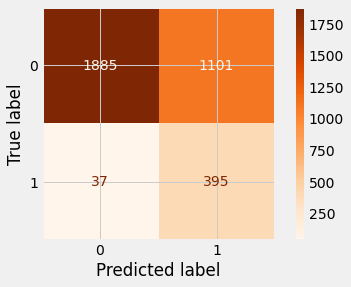

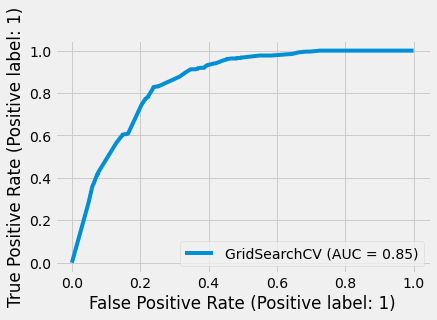

In [142]:
binary_metrics(X_train, y_train, X_test, y_test, gs_rf)


> ### Random Forest Smote

In [144]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [145]:
smo = SMOTE()
pipe = Pipeline([
    ('over', SMOTE(random_state=42)), 
    ('rf', RandomForestClassifier(n_estimators=150, 
                                  max_depth=2, 
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  max_features=0.5,
                                  bootstrap=False,
                                  random_state=42))
])


# sets the pipe params
pipe_params = {'over__sampling_strategy':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#                'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
              }

# Instantiates the gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                     , verbose=1
                     , scoring = 'recall'
                    , return_train_score=True
                )
# Fit training data
gs.fit(X_train, y_train)

# gridsearch optimization

print('best parameters:', gs.best_estimator_)
print('best score:', gs.best_score_)
print('recall on train data:', gs.score(X_train, y_train))
print('recall on test data:', gs.score(X_test, y_test))


Fitting 3 folds for each of 7 candidates, totalling 21 fits
best parameters: Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=0.5, min_samples_leaf=2,
                                        n_estimators=150, random_state=42))])
best score: 0.8231574575348745
recall on train data: 0.8424710424710424
recall on test data: 0.8310185185185185



Train Accuracy: 0.76406905
Test Accuracy: 0.76945582

Train Recall: 0.84247104
Test Recall: 0.83101852

 Confusion Matrix of Test Data


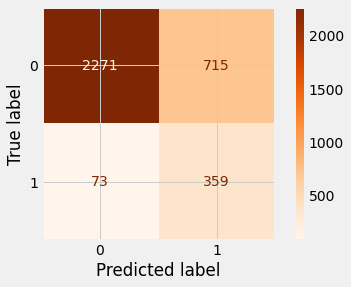

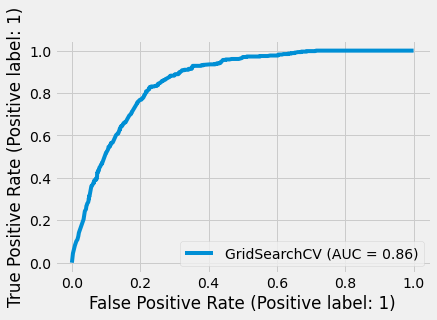

In [146]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gs)

### Random Forest Undersampling 

In [204]:

pipe = Pipeline([
    ('under',RandomUnderSampler(random_state=42)), 
    ('rf', RandomForestClassifier(n_estimators=150, 
                                  max_depth=2, 
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  max_features=0.5,
                                  bootstrap=False,
                                  random_state=42))
])


# sets the pipe params
pipe_params = {'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
              }

# Instantiates the gridsearch
gs_under_rf = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                , verbose=1
                , scoring ='recall'
                , return_train_score=True
                )
# Fit training data
gs_under_rf.fit(X_train, y_train)

# gridsearch optimization

print('best parameters:', gs_under_rf.best_params_)
print('best score:', gs_under_rf.best_score_)
print('recall on train data:', gs_under_rf.score(X_train, y_train))
print('recall on test data:', gs_under_rf.score(X_test, y_test))

Fitting 3 folds for each of 7 candidates, totalling 21 fits
best parameters: {'under__sampling_strategy': 1.0}
best score: 0.8579083240239468
recall on train data: 0.8594594594594595
recall on test data: 0.8495370370370371



Train Accuracy: 0.74719594
Test Accuracy: 0.75160913

Train Recall: 0.85945946
Test Recall: 0.84953704
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      2986
           1       0.32      0.85      0.46       432

    accuracy                           0.75      3418
   macro avg       0.65      0.79      0.65      3418
weighted avg       0.89      0.75      0.79      3418


 Confusion Matrix of Test Data


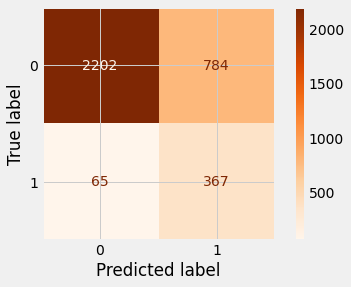

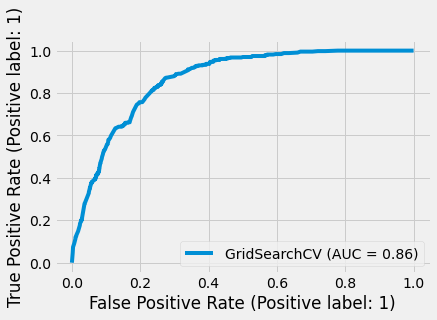

In [205]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gs_under_rf)


> ### Logistic Regression Smote

In [78]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [150]:
smo = SMOTE()
pipe = Pipeline([
    ('over', SMOTE(random_state=42)), 
    ('logreg', LogisticRegression(class_weight = 'balanced',
                                 max_iter= 1000))
])

# sets the pipe params
pipe_params = {'over__sampling_strategy':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
              }

# Instantiates the gridsearch
gs_logreg = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                     , verbose=1
                     , scoring = 'recall'
                    , return_train_score=True
                )


# Fit training data
gs_logreg.fit(X_train, y_train)

# gridsearch optimization

print('best parameters:', gs_logreg.best_params_)
print('best score:', gs_logreg.best_score_)
print('recall on train data:', gs_logreg.score(X_train, y_train))
print('recall on test data:', gs_logreg.score(X_test, y_test))

Fitting 3 folds for each of 7 candidates, totalling 21 fits
best parameters: {'over__sampling_strategy': 0.4}
best score: 0.685729426255335
recall on train data: 0.6895752895752896
recall on test data: 0.7013888888888888



Train Accuracy: 0.82268604
Test Accuracy: 0.82358104

Train Recall: 0.68957529
Test Recall: 0.70138889

 Confusion Matrix of Test Data


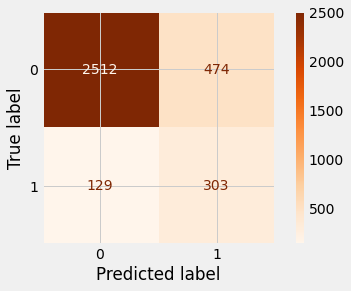

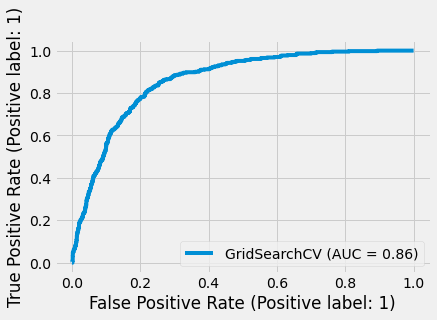

In [151]:
binary_metrics(X_train, y_train, X_test, y_test, gs_logreg)

### Logistic Regression Undersampling

In [152]:
pipe = Pipeline([ 
    ('under',RandomUnderSampler(random_state=42)), 
    ('logreg', LogisticRegression(class_weight = 'balanced',
                                 max_iter= 1000))
])

# sets the pipe params
pipe_params = {
               'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
              }

# Instantiates the gridsearch
gs_logreg = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                     , verbose=1
                     , scoring = 'recall'
                    , return_train_score=True
                )


# Fit training data
gs_logreg.fit(X_train, y_train)

# gridsearch optimization

print('best parameters:', gs_logreg.best_params_)
print('best score:', gs_logreg.best_score_)
print('recall on train data:', gs_logreg.score(X_train, y_train))
print('recall on test data:', gs_logreg.score(X_test, y_test))

Fitting 3 folds for each of 7 candidates, totalling 21 fits
best parameters: {'under__sampling_strategy': 0.7}
best score: 0.8455608547449228
recall on train data: 0.8463320463320463
recall on test data: 0.8472222222222222



Train Accuracy: 0.77304204
Test Accuracy: 0.78057343

Train Recall: 0.84633205
Test Recall: 0.84722222

 Confusion Matrix of Test Data


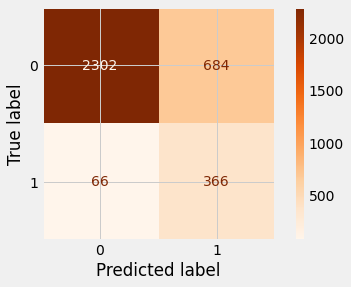

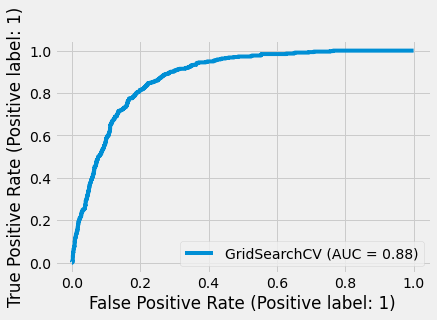

In [153]:
binary_metrics(X_train, y_train, X_test, y_test, gs_logreg)

### Gradient Boosting with Undersampling

In [157]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [161]:
pipe = Pipeline([ 
    ('under',RandomUnderSampler(random_state=42)), 
    ('gb', GradientBoostingClassifier())
])

# sets the pipe params

param_grid_gb = {
                    'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8], 
                    'gb__n_estimators': [50, 100],
                    'gb__learning_rate': [1, 0.6, 0.2],
                    'gb__max_features': ['auto', 'sqrt'],
                    'gb__min_samples_leaf': [2, 5],
                    'gb__min_samples_split': [2, 5, 10],
                    'gb__max_depth':[10, 30],
                    'gb__random_state': [42]
                 }

In [162]:
#xgb_grid_search_res = GridSearchCV(xgb_clf, param_grid_xgb, cv=10, scoring="accuracy", return_train_score=True, verbose=True, n_jobs=-1)
gb_gs= GridSearchCV(
        estimator=pipe
    , param_grid= param_grid_gb
    , cv=3
    , scoring="recall"
    , return_train_score=True
    , verbose=1, n_jobs=-1)
gb_gs.fit(X_train, y_train)

print('best parameters:', gb_gs.best_params_)
print('best score:', gb_gs.best_score_)
print('recall on train data:', gb_gs.score(X_train, y_train))
print('recall on test data:', gb_gs.score(X_test, y_test))

Fitting 3 folds for each of 720 candidates, totalling 2160 fits
best parameters: {'gb__learning_rate': 0.2, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__min_samples_leaf': 2, 'gb__min_samples_split': 5, 'gb__n_estimators': 50, 'gb__random_state': 42, 'under__sampling_strategy': 0.8}
best score: 0.7814764687347827
recall on train data: 0.9984555984555985
recall on test data: 0.7731481481481481


In [163]:
# gridsearch optimization
print('best score:', gb_gs.best_score_)
print('best parameters:', gb_gs.best_params_)
print('recall on train data:', gb_gs.score(X_train, y_train))
print('recall on test data:', gb_gs.score(X_test, y_test))

best score: 0.7814764687347827
best parameters: {'gb__learning_rate': 0.2, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__min_samples_leaf': 2, 'gb__min_samples_split': 5, 'gb__n_estimators': 50, 'gb__random_state': 42, 'under__sampling_strategy': 0.8}
recall on train data: 0.9984555984555985
recall on test data: 0.7731481481481481



Train Accuracy: 0.84258266
Test Accuracy: 0.78730252

Train Recall: 0.9984556
Test Recall: 0.77314815

 Confusion Matrix of Test Data


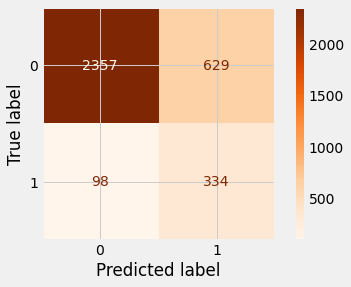

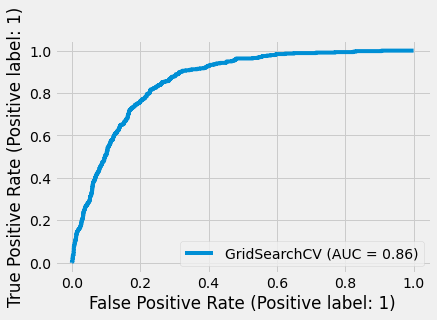

In [164]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gb_gs)

### Multinomial Naive Bayes with Undersampling

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [193]:
pipe = Pipeline([ 
    ('under',RandomUnderSampler(random_state=42)), 
    ('nb', MultinomialNB())
])

# sets the pipe params

param_grid_nb = {
                    'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8], 
                    'nb__alpha': list(np.linspace(0.0, 1.0, num=5)),
                    'nb__fit_prior': [True, False]
                 }

# Fit our training data to the Grisearch.
gb_nb= GridSearchCV(
        estimator=pipe
    , param_grid= param_grid_nb
    , cv=3
    , scoring="recall"
    , return_train_score=True
    , verbose=1
    , n_jobs=-1)
gb_nb.fit(X_train, y_train)

# Fit our training data to the Grisearch.
gb_nb.fit(X_train, y_train)
print(gb_nb.best_params_)
print(gb_nb.best_estimator_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'nb__alpha': 1.0, 'nb__fit_prior': False, 'under__sampling_strategy': 0.5}
Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('nb', MultinomialNB(fit_prior=False))])


In [194]:
print('best parameters:', gb_nb.best_params_)
print('best score:', gb_nb.best_score_)
print('recall on train data:', gb_nb.score(X_train, y_train))
print('recall on test data:', gb_nb.score(X_test, y_test))

best parameters: {'nb__alpha': 1.0, 'nb__fit_prior': False, 'under__sampling_strategy': 0.5}
best score: 0.7953617770903154
recall on train data: 0.7876447876447876
recall on test data: 0.7962962962962963



Train Accuracy: 0.71715595
Test Accuracy: 0.72908133

Train Recall: 0.78764479
Test Recall: 0.7962963
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      2986
           1       0.29      0.80      0.43       432

    accuracy                           0.73      3418
   macro avg       0.63      0.76      0.62      3418
weighted avg       0.88      0.73      0.77      3418


 Confusion Matrix of Test Data


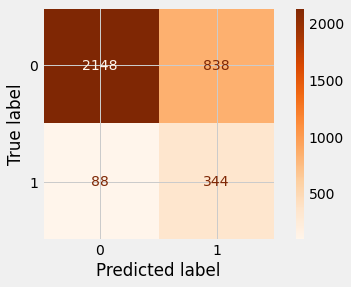

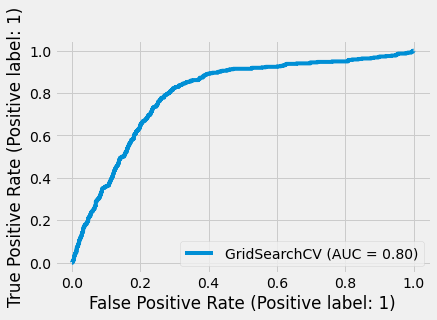

In [195]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gb_nb)

### Knn with undersampling

In [200]:
pipe = Pipeline([ 
    ('under',RandomUnderSampler(random_state=42)), 
    ('knn', KNeighborsClassifier())
])

# sets the pipe params

param_grid_knn ={
    'knn__n_neighbors' : [1 ,2, 3, 4, 5, 6, 7],
    'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8], 
}

# Fit our training data to the Grisearch.
gb_knn= GridSearchCV(
        estimator=pipe
    , param_grid= param_grid_knn
    , cv=3
    , scoring="recall"
    , return_train_score=True
    , verbose=1
    , n_jobs=-1)
gb_knn.fit(X_train, y_train)

# Fit our training data to the Grisearch.
gb_knn.fit(X_train, y_train)
print(gb_knn.best_params_)
print(gb_knn.best_estimator_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Fitting 3 folds for each of 35 candidates, totalling 105 fits
{'knn__n_neighbors': 7, 'under__sampling_strategy': 0.8}
Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.8)),
                ('knn', KNeighborsClassifier(n_neighbors=7))])



Train Accuracy: 0.75568126
Test Accuracy: 0.74078408

Train Recall: 0.84015444
Test Recall: 0.80555556
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      2986
           1       0.30      0.81      0.44       432

    accuracy                           0.74      3418
   macro avg       0.63      0.77      0.64      3418
weighted avg       0.88      0.74      0.78      3418


 Confusion Matrix of Test Data


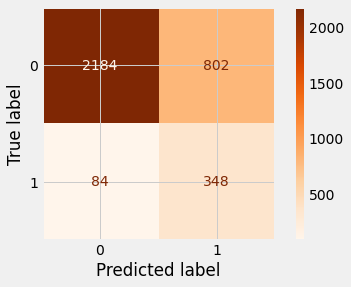

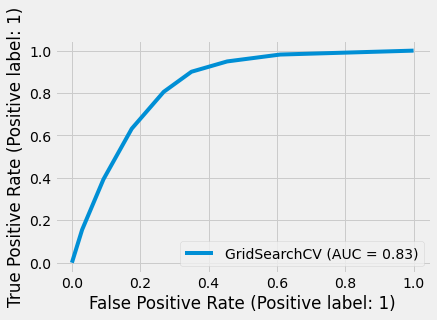

In [201]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gb_knn)

# Summary

| Classifier           | Imbalanced Technique | Recall Train | Recall Test | Accuracy Train | Accuracy Test |  AUC | False   Negatives | False Positives |
|----------------------|:--------------------:|:------------:|:-----------:|:--------------:|:-------------:|:----:|:-----------------:|:---------------:|
| Logistic Regression  |         none         |      28      |      24     |       88       |       88      | 0.88 |        327        |        95       |
| Logistic Regression  |    weighted Class    |      85      |      86     |       76       |       77      | 0.87 |         59        |       738       |
| Logistic Regression  |         smote        |      69      |      70     |       82       |       82      | 0.86 |        129        |       474       |
| Logistic Regression  |     undersampling    |      85      |      85     |       77       |       78      | 0.88 |         66        |       684       |
| Random Forest        |    weighted Class    |      91      |      91     |       66       |       67      | 0.85 |         37        |       1101      |
| Random Forest        |         smote        |      84      |      83     |       76       |       77      | 0.86 |         73        |       715       |
| Random Forest        |     undersampling    |      86      |      85     |       75       |       75      | 0.86 |         65        |       784       |
| Gradient Boosting    |     undersampling    |      100     |      77     |       84       |       79      | 0.86 |         98        |       629       |
| Knn                  |     Undersampling    |      84      |      81     |       76       |       74      | 0.83 |         84        |       802       |
| Multinomial NB       |     Undersampling    |      79      |      79     |       72       |       73      | 0.80 |         88        |       838       |

___ 
### Interpret Coefficients of Logistic Regression

In [26]:
lr_final = LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=3000, penalty='l1',
                                    solver='saga')
lr_final.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=3000, penalty='l1',
                   solver='saga')

In [27]:
# Create a dataframe that houses the Coefficients of the logistic model.
coeffs = pd.DataFrame(lr_final.coef_[0], index=X.columns, columns=['coeffs']).rename({'coeffs':'Coefficients'})

#Rename Title from Coeffs, to Coefficients.
coeffs.rename(columns={"coeffs": "coefficients"}, inplace=True)

#convert cofficeints to log odds.
coeffs['percent_odd'] = coeffs['coefficients'].map(lambda x : np.exp(x) - 1)

# Sort coefficients, by feature importances.
coeffs.sort_values(by= 'coefficients', ascending=False, inplace=True)

#show the top 10 Coefficients.
coeffs

,coefficients,percent_odd
BPQ020_1,0.513871,0.671750
MCQ300C_1,0.343601,0.410016
BMXBMI,0.059963,0.061798
RIDAGEYR,0.055486,0.057054
PAQ665_1,0.000000,0.000000
SMQ040_2,0.000000,0.000000
SMQ040_1,0.000000,0.000000
RIDRETH3_7,0.000000,0.000000
RIDRETH3_6,0.000000,0.000000
RIDRETH3_4,0.000000,0.000000


- If one has a high blood pressure, the odds of suffering from diabetes increases by 67%

- If one has close relatives that are diabetic, the odds of being diabetic increases by 41%

- If one has no close relatives that are diabetic, the odds of being diabetic decreases by 55%

- as age increases by one year, the odds of being diabetic increases by 6%

- as BMI increases by one unit, the odds of being diabetic increases by 6%

- As number of pregnancy increases by one, the odds of being diabetic decreases by 5%

- As one is non-hispanic white, the odds of getting diabetic decreases by 17%. Other races didn't have a stronger predictive power. This could have due to lower number of representation of other races in the surveys. 




In [186]:
pd.DataFrame(lr_final.coef_, columns=X.columns)

,RIDAGEYR,BMXBMI,RHQ160,wh_ratio,PAQ650_1,PAQ650_2,PAQ605_1,PAQ605_2,PAQ620_1,PAQ620_2,...,RIDRETH3_3,RIDRETH3_4,RIDRETH3_6,RIDRETH3_7,MCQ300C_1,MCQ300C_2,SMQ040_1,SMQ040_2,BPQ020_1,BPQ020_2
0,0.055485,0.059961,-0.049898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.180957,0.0,0.0,0.0,0.343621,-0.787859,0.0,0.0,0.513878,0.0


In [214]:
import pickle

# 'with statement'
with open('./models/diabetes_lr_weighted.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(lr_final, pickle_out)

In [28]:
lr_final.predict_proba(X_test)

array([[0.66169457, 0.33830543],
       [0.6038843 , 0.3961157 ],
       [0.43957709, 0.56042291],
       ...,
       [0.38677498, 0.61322502],
       [0.45861307, 0.54138693],
       [0.97133113, 0.02866887]])

In [29]:
lr_final.predict(X_test)

array([0, 0, 1, ..., 1, 1, 0])